# Basic Frankenstein tutorial

In this tutorial we will show how to
    - Load an example dataset
    - Deproject it
    - Fit it using Frankenstein
    - Make some diagnostic plots
    - Esimtate the uncertainty
    - Save the profile to disc
    
Note that before you can run this tutorial you will need to have installed Frankenstein. Follow the instructings in README.md
    
## First, let's import the packages required:
    - Frankenstein
    - numpy
    - matplotlib for plotting

In [1]:
from __future__ import print_function

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import frankenstein as frank
from frankenstein.constants import rad_to_arcsec

## Next, let's define some useful helper functions for later.

In [2]:
# Enables plotting of negative data on a log-scale
def plot_log_abs(x, y, **kwargs):
    c = plt.loglog(x, y, **kwargs)[0].get_color()
    
    kwargs = dict(kwargs) 
    kwargs['c'] = c
    kwargs['label'] = None
    plt.loglog(x, -y, ls='--', **kwargs)

# Generate a set of binned data
def bin_uv_data(baselines, vis, weights, Nbins=512):
    edges = np.histogram_bin_edges(np.log(baselines), bins=Nbins)
    idx = np.digitize(np.log(baselines), edges)

    kbins = np.exp(0.5*(edges[1:] + edges[:-1]))

    bin_obs = np.zeros_like(kbins)
    bin_weights = np.zeros_like(kbins)

    for i in range(len(kbins)):
        yi = vis[np.where(idx==i)]
        if len(yi) > 0:
            wi = weights[np.where(idx==i)]
            bin_obs[i] = np.sum(yi*wi) / wi.sum()
            
            if len(yi) > 1:
                bin_weights[i] = np.sum(yi**2 * wi) / wi.sum() - bin_obs[i]**2
                bin_weights[i] = (len(yi) - 1) / bin_weights[i]
            else:
                bin_weights[i] = np.mean(wi)
            
    idx = bin_weights > 0
    kbins, bin_obs, bin_weights = map(lambda x: x[idx], [kbins, bin_obs, bin_weights])
    
    return kbins, bin_obs, bin_weights

## Loading example dataset

For this tutorial we will use the AS 209 continuum dataset from DSHARP.  The uv-points have been extracted from MS-table and are provided in the examples directory. 

For comparison we will also load the CLEAN profile generated by DSHARP.

    TODO: Make this use internal functions.

In [3]:
uv_AS209_DHSARP = np.load('AS209_continuum.npz')

The header shows that the uv points are already in units of $\lambda$, so we do not need to convert them. 


Let's just extract variables we need and confirm that the visibilities are complex

In [4]:
print(uv_AS209_DHSARP['header'])

u, v, vis, weights = [uv_AS209_DHSARP[k] for k in ['u', 'v', 'V', 'weights']]
print(vis.dtype)

{u'units': [u'lambda', u'lambda', u'Jy', u'Jy', u'None', u'Hz', u'None'], u'array_shape_orig': (1, 977774), u'datacolumn': u'DATA', u'columns': [u'u', u'v', u'V', u'weights', u'freqs', u'spws'], u'originalMS': u'/opt/services/djangoapp/media/MS/297/AS209_continuum_nopnt_nofl.ms'}
complex128


Load the radial profile. We store it in an object for convenience

Text(0.5,1,'CLEAN profile for AS 209')

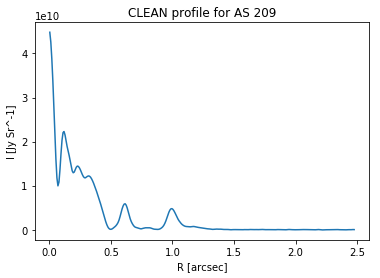

In [5]:
class InterpolatedDSHARPProfile(object):
    """Wrapper for the DSHARP radial profile text files
    
    Due to problems with the original files, we compute the intensity from the brightness temperature.
    """
    def __init__(self, data_file, frequency, norm=1):
        data = np.genfromtxt(data_file, unpack=True)

        r, T = data[1], data[4]

        wave = 299792458.0 / frequency

        I = 2 * 1.3806503e-23 * T  / wave**2
        I *= 1e26 / norm

        r /= rad_to_arcsec
            
        self.r = r
        self.Inu = I
 
AS209_profile = InterpolatedDSHARPProfile('AS_209_profile.dat', frequency=239e9)

plt.plot(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu)
plt.xlabel('R [arcsec]')
plt.ylabel('I [Jy Sr^-1]')
plt.title('CLEAN profile for AS 209')

## Next we need to deproject the dataset

Since AS 209 is not face on we need to de-project the disc before we can fit using an axis-symmetric model. We will do that by fitting a gaussian in visibility space.

In [6]:
from frankenstein.geometry import fit_geometry_gaussian, SourceGeometry

fitted_geometry = fit_geometry_gaussian(u,v,vis,weights)

print("Fitted geometry:")
print("\tPA, inclination (deg):\t\t {:.3f} {:.3f}".format(fitted_geometry.PA*180/np.pi, fitted_geometry.inc*180/np.pi))
print("\tPhase centre, dRA, dDec (mas):\t {:.3f} {:3f}".format(1e3*fitted_geometry.dRA, 1e3*fitted_geometry.dDec))


Fitted geometry:
	PA, inclination (deg):		 86.470 -33.933
	Phase centre, dRA, dDec (mas):	 0.916 -0.248995


The fit can also be performed without fitting for the phase centre:

In [7]:
fitted_geometry2 = fit_geometry_gaussian(u,v,vis,weights, phase_centre=(0,0))

print("Fitted geometry:")
print("\tPA, inclination (deg):\t\t {:.3f} {:.3f}".format(fitted_geometry2.PA*180/np.pi, fitted_geometry2.inc*180/np.pi))
print("\tPhase centre, dRA, dDec (mas):\t {:.3f} {:.3f}".format( 1e3*fitted_geometry2.dRA, 1e3*fitted_geometry2.dDec))

Fitted geometry:
	PA, inclination (deg):		 86.472 -33.935
	Phase centre, dRA, dDec (mas):	 0.000 0.000


Since these fitted results agree with the published values, we will use those

Text(0.5,1,'Binned visibilites')

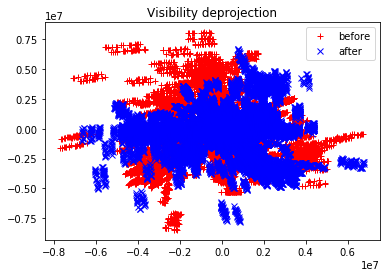

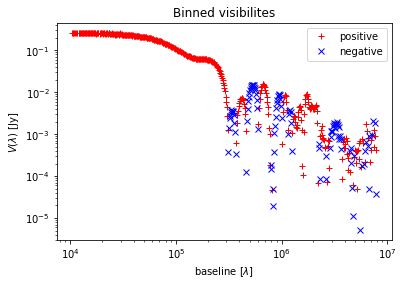

In [8]:
# TODO: Jeff check these parameters
geometry = SourceGeometry(dRA=1.9e-3, dDec=-2.5e-3, inc=34.97*np.pi/180, PA=85.76*np.pi/180)

#Plot a subset of the uv-points before and after de-projecion:
plt.plot(u[::10],v[::10], 'r+', label='before')

u,v,vis = geometry.apply_correction(u,v,vis)

plt.plot(u[::10],v[::10], 'bx', label='after')
plt.legend()
plt.title('Visibility deprojection')

# Plot the data (binned).
#  NB: We will fit the un-binned data
uv_bin, vis_bin, w_bin = bin_uv_data(np.hypot(u,v), vis.real, weights)

plt.figure()
plt.loglog(uv_bin, +vis_bin.real, 'r+',label='positive')
plt.loglog(uv_bin, -vis_bin.real, 'bx',label='negative')
plt.legend()
plt.xlabel('baseline [$\lambda$]')
plt.ylabel('$V(\lambda)$ [Jy]')
plt.title('Binned visibilites')

## Now we fit the data

From the radial profile we know that the emission is close to zero beyond 1.6arcsec, so lets fit to there.

Also use 300 bins, $\alpha=1.05$ and $w_s = 1/\sigma_s^2 = 0.01$

Note that we only fit the real component of the visibilities as an axi-symmetric source has zero imaginary component

In [9]:
from frankenstein import FrankFitter

Rmax = 1.6/rad_to_arcsec

FF = FrankFitter(Rmax, 300, alpha=1.05, w_smooth=1e-2)

uv = np.hypot(u, v)

sol = FF.fit(uv, vis.real, weights)

Lets make some diagnostic plots

(1e-05, 1.0565807895181774)

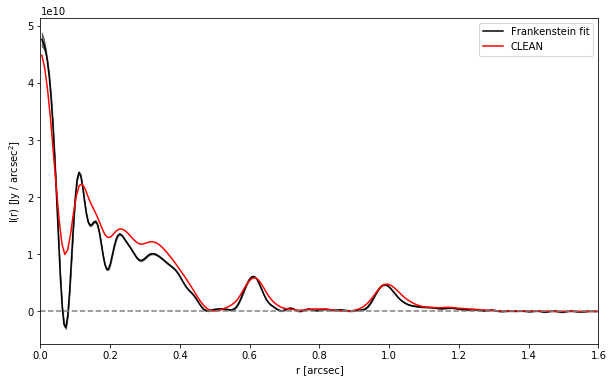

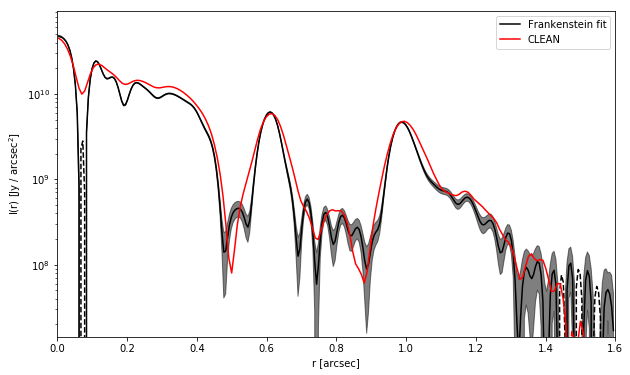

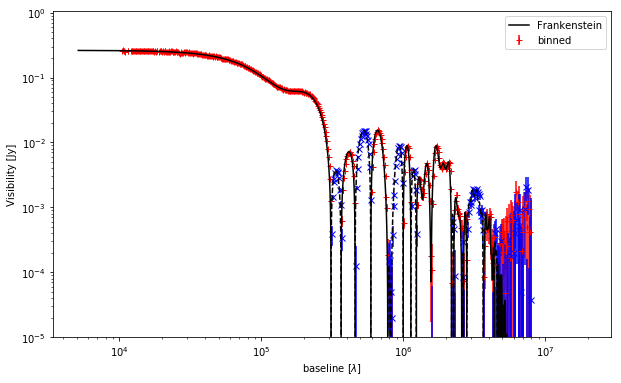

In [10]:
plt.figure(figsize=(10,6))

plt.plot(sol.r*rad_to_arcsec, sol.mean, 'k', label='Frankenstein fit')

# Plot an estimate of the confidence interval using the covariance matrix
err = np.diag(sol.covariance)**0.5
plt.fill_between( sol.r*rad_to_arcsec, sol.mean-err, sol.mean+err, color='k', alpha=0.5)
   
# Plot the CLEAN profile
plt.plot(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, 'r', label='CLEAN')
    
plt.xlabel('r [arcsec]')
plt.ylabel('I(r) [Jy / arcsec${^2}$]')
plt.axhline(0, c='0.5', ls='--')
plt.xlim(0, 1.6)
plt.legend()

# Plot in logspace
plt.figure(figsize=(10,6))

plot_log_abs(sol.r*rad_to_arcsec, sol.mean, c='k', label='Frankenstein fit')
plt.fill_between(sol.r*rad_to_arcsec, sol.mean-err, sol.mean+err, color='k', alpha=0.5)

plot_log_abs(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, c='r', label='CLEAN')

plt.xlabel('r [arcsec]')
plt.ylabel('I(r) [Jy / arcsec${^2}$]')
plt.ylim(ymin=3e-4*sol.mean.max())
plt.xscale('linear')
plt.xlim(0, 1.6)
plt.legend()

# Plot the visibilies
plt.figure(figsize=(10,6))
l = plt.errorbar(uv_bin, vis_bin, yerr=w_bin**-0.5,marker='+', ls='none', c='r', label='binned', zorder=-1)
plt.errorbar(uv_bin, -vis_bin, yerr=w_bin**-0.5,marker='x', ls='none', c='b', zorder=-1)

ki = np.logspace(np.log10(min(uv.min(), sol.q[ 0])) - 0.3, 
                 np.log10(max(uv.max(), sol.q[-1])) + 0.0,
                 10**4)

plot_log_abs(ki, sol.predict(ki), c='k', label='Frankenstein')
plt.legend()
plt.xlabel('baseline [$\lambda$]')
plt.ylabel('Visibility [Jy]')
plt.ylim(ymin=1e-5)


## Sensitivity to parameters

Compare with a fit with weaker smoothing. For this choice the model tries to fit some of the longest baseline data, adding noise.

    TODO: Decide on the best parameters to show

In [11]:
FF2 = FrankFitter(Rmax, 300, alpha=1.05, w_smooth=1e-6)

uv = np.hypot(u, v)

sol2 = FF2.fit(uv, vis.real, weights)
err2 = np.diag(sol2.covariance)**0.5

(1e-05, 1.0565807895181774)

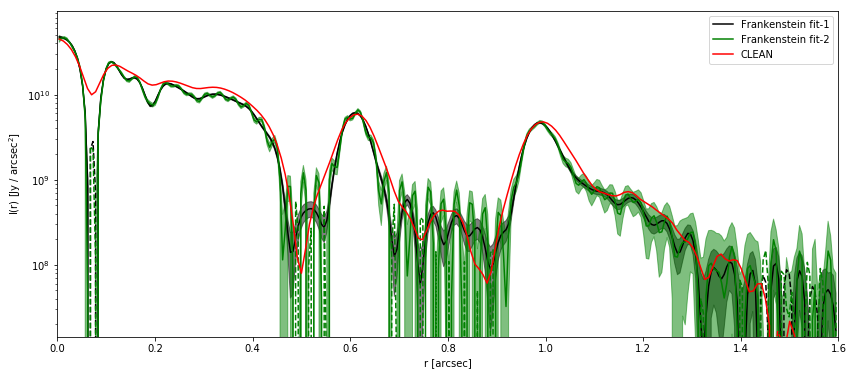

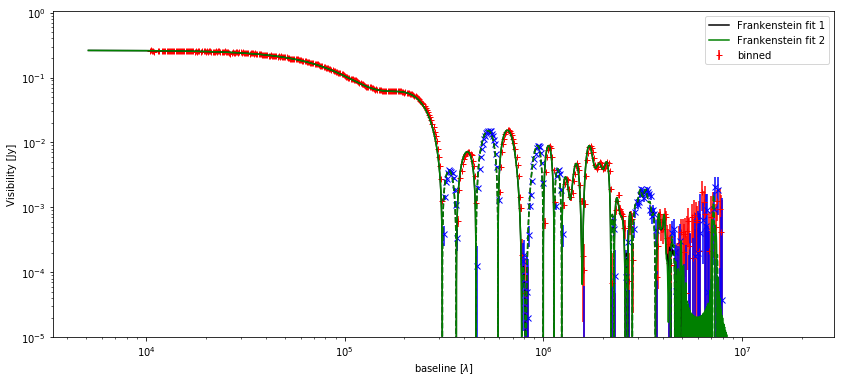

In [12]:

# Plots real-space
plt.figure(figsize=(14,6))
plot_log_abs(sol.r*rad_to_arcsec, sol.mean, c='k', label='Frankenstein fit-1')
plt.fill_between(sol.r*rad_to_arcsec, sol.mean-err, sol.mean+err, color='k', alpha=0.5)
plot_log_abs(sol2.r*rad_to_arcsec, sol2.mean, c='g', label='Frankenstein fit-2')
plt.fill_between(sol.r*rad_to_arcsec, sol2.mean-err2, sol2.mean+err2, color='g', alpha=0.5)

plot_log_abs(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, c='r', label='CLEAN')

plt.xlabel('r [arcsec]')
plt.ylabel('I(r) [Jy / arcsec${^2}$]')
plt.axhline(0, c='0.5', ls='--')
plt.ylim(ymin=3e-4*sol.mean.max())
plt.xscale('linear')
plt.xlim(0, 1.6)
plt.legend()

# Plot the visibilies
plt.figure(figsize=(14,6))
l = plt.errorbar(uv_bin, vis_bin, yerr=w_bin**-0.5,marker='+', ls='none', c='r', label='binned', zorder=-1)
plt.errorbar(uv_bin, -vis_bin, yerr=w_bin**-0.5,marker='x', ls='none', c='b', zorder=-1)

ki = np.logspace(np.log10(min(uv.min(), sol.q[ 0])) - 0.3, 
                 np.log10(max(uv.max(), sol.q[-1])) + 0.0,
                 10**4)

plot_log_abs(ki, sol.predict(ki),  c='k', label='Frankenstein fit 1')
plot_log_abs(ki, sol2.predict(ki), c='g', label='Frankenstein fit 2')

plt.legend()
plt.xlabel('baseline [$\lambda$]')
plt.ylabel('Visibility [Jy]')
plt.ylim(ymin=1e-5)
